# Linear Regression on Cellphone Price
By: Andy Hu, Tim Yang, Amanda Gao, Yingqian Shi

April 16, 2025

## 1. Introduction

### 1.1 Dataset Description

We obtained our dataset from [Kaggle](https://www.kaggle.com/datasets/mohannapd/mobile-price-prediction), a data science and machine learning platform. The dataset contains various hardware and software features of mobile phones along with their corresponding selling prices. The data was collected through an observational study by recording existing phone specifications and market prices, rather than through a controlled experiment.

|Variable Name | Description | Type |
|--------------|-------------|------|
|Price | Price of a phone (dollars)|  Continuous |
|Weight |Weight of a phone (grams) | Continuous |
|PPI | Phone Pixel Density (pixels per inch) |Continuous |
|CPU Frequency | CPU Frequency clock speed (GHz) | Continuous| 
|Battery | Capacity of battery (mAh) | Continuous |
|Thickness | Thickness of the phone (mm) | Continuous | 
|Internal Memory | Memory in the phone (0GB, 4GB, 8GB, 16GB, 32GB, 64GB, 128GB, 256GB) | Categorical |
|CPU Cores |Number of Cores in CPU (0, 2, 4, 6, 8) | Categorical |

### 1.2 Pre-selection of Variables

We excluded product ID and sales number because they are unique identifiers.  We excluded resolution, RAM, rear cam, and front cam because we are unsure about their units. We made educated guesses on units of variables above since they are not explicitly stated in the dataset.

### 1.3 Motivation
By analyzing key smartphone features, we can use linear regression to examine the relationships between these features and the price of a phone. This inferential approach provides valuable insights into how different phone specifications influence its price. For consumers, it allows them to understand the extent to which factors like weight, CPU performance, memory, and screen resolution contribute to the cost of a phone, helping them evaluate whether the price of any phone they have their eyes on is justified. For companies, this model reveals which features have the strongest relationships with price, enabling them to refine their pricing strategies, and make data-driven decisions regarding product offerings and prices.

Cellphone usage has skyrocketed in the past years as technology has evolved, where over 98% of Americans own a phone [(Sidoti et al., 2024)](https://www.pewresearch.org/internet/fact-sheet/mobile/). The smartphone industry is massive, and there is a lot of competition between major brands like Apple and Samsung; these companies are competing for a share of the more than 1 billion phones sold globally each year [(Laricchia, 2024)](https://www.statista.com/statistics/263437/global-smartphone-sales-to-end-users-since-2007/). Our research seeks to understand how these companies determine their pricing strategies, offering consumers a clearer understanding of the factors that influence the costs of their devices.

### 1.4 Research Question
How are a cell phone's specifications, specifically its resolution (in ppi) and number of cores, associated with its final market price?


## 2. Analysis

In [1]:
# Imports
suppressMessages({
    library(tidyverse)
    library(GGally)
    library(dplyr)
    library(leaps)
    library(car)
    library(gridExtra)
})

### 2.1 Initial Data Cleaning

A summary of the initial data cleaning phase is below:
- Rename the columns to lowercase and camelCase
- Drop columns identified in 1.1 Pre-selection of variables
- Transform the memory column so all measurements are on the same scale
- Delete rows where there is no memory or where there are no cores, as this does not make sense in a cellphone
- Convert core and memory columns to factors
- Delete duplicate column entries

In [2]:
# Load dataset and rename columns
data = read.csv("https://raw.githubusercontent.com/andyh031/stat306-project/refs/heads/main/data/cellphone.csv")
colnames(data) = c(
    "id", "price", "salesNumber", "weight", "resolution", "ppi",
    "core", "freq", "memory", "ram", "rearCam", "frontCam",
    "battery", "thickness"
)

# Pre-selection of variables: Remove the variables stated in 1.1 (id, salesNumber, resolution, ram, rearCam, frontCam)
drop_columns = c("id", "salesNumber", "resolution", "ram", "rearCam", "frontCam")
data = data |> select(-all_of(drop_columns))

# Data has memory levels of 0.004, 0.128, 0.256, 0, 4, 8, 16, 32, 64, 128, so we transform the data appropriately to the same scale
data = data |> mutate(memory = ifelse(memory < 1, memory * 1000, memory))

# Filter data that has core = 0 or memory = 0, as this does not make sense in the context of a phone and was likely imputed
data = data |> filter(memory > 0) |> filter(core > 0)

# Convert core and memory into factors so R knows they are categorical and not just numerical
factor_cols = c("core", "memory")
data = data |> mutate(across(all_of(factor_cols), as.factor))

# Lots of duplicate data, so only get unique counts
data = unique(data)
nrow(data)

[1] 75

We have 75 data points to do our analysis on after dropping duplicates and removing potential data entry errors that were imputed (where memory or cores was equal to 0). We are left with 7 covariates and 1 response.

In [3]:
# Show the dataframe
head(data)

,price,weight,ppi,core,freq,memory,battery,thickness
,<int>,<dbl>,<int>,<fct>,<dbl>,<fct>,<int>,<dbl>
1,2357,135.0,424,8,1.35,16,2610,7.4
2,1749,125.0,233,2,1.30,4,1700,9.9
3,1916,110.0,312,4,1.20,8,2000,7.6
4,1315,118.5,233,2,1.30,4,1400,11.0
6,2137,150.0,401,4,2.30,16,2500,9.5
7,1238,134.1,233,2,1.20,8,1560,11.7


### 2.2 Exploratory Data Analysis

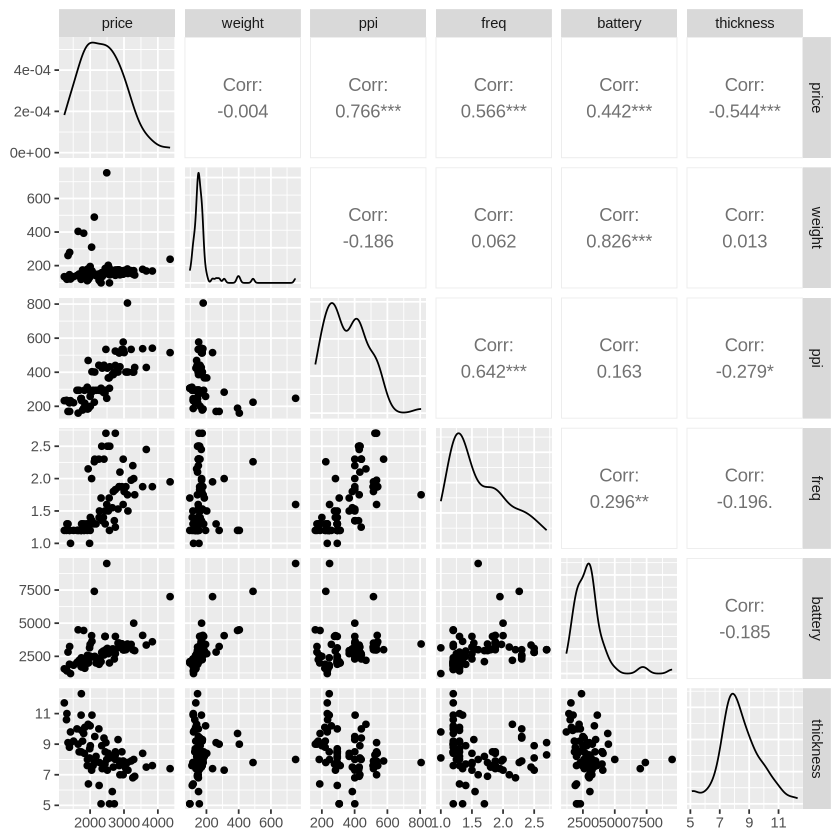

In [4]:
# Create a ggpairs plot to visualize the pairwise relationships between numerical variables
numeric_data = data |> select(where(is.numeric))
ggpairs(numeric_data)

We notice `weight` and `thickness` are negatively correlated with price, while `ppi`, `freq`, and `battery` are positively correlated with the price. Looking at the relationship between each covarite with the response, we see that the relationships are all linear. Also, we are wary that there may be signs of multicollinearity because many of the pairwise plots between covariates seem to have a relationship, such as the one between `battery` and `weight` (correlation of 0.826), or `freq` and `ppi` (correlation of 0.642).

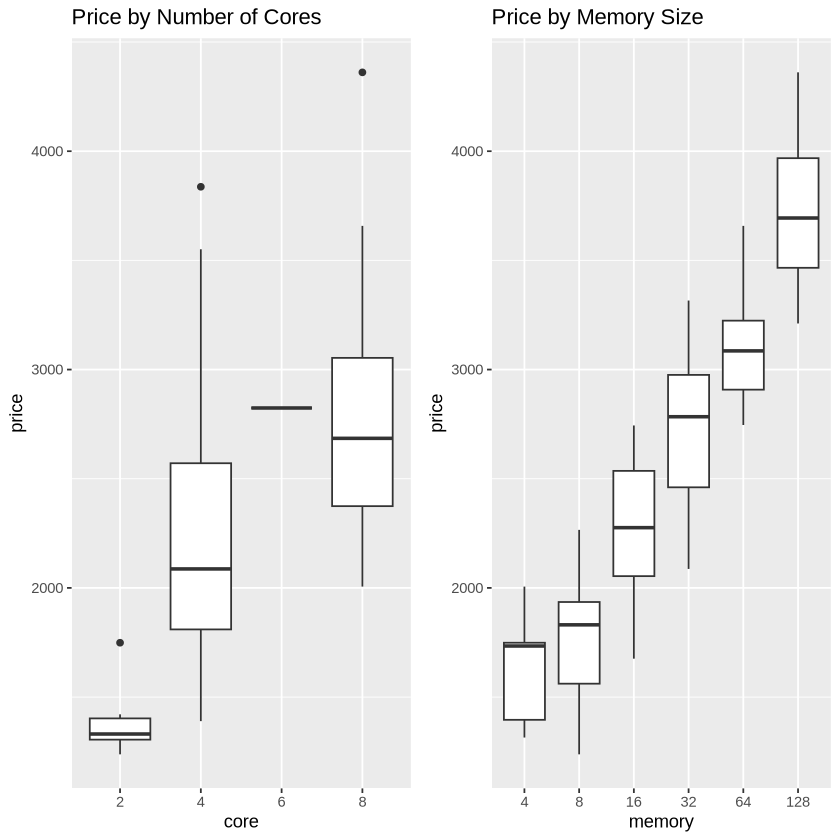

In [5]:
# Boxplot: core vs price
core_plot = ggplot(data, aes(x = core, y = price)) +
    geom_boxplot() +
    labs(title = "Price by Number of Cores")

# Boxplot: memory vs price
memory_plot = ggplot(data, aes(x = memory, y = price)) +
    geom_boxplot() +
    labs(title = "Price by Memory Size")

grid.arrange(core_plot, memory_plot, ncol = 2)

We notice that for both `core` and `memory`, a higher level corresponds to a higher selling price. We see that there is very little data for `core = 6` and that it is completely within the same bounds as `core = 8`, so we combine them together (merge core = 6 into the core = 8 level).

In [6]:
# Recode the level of core = 6 to core = 8.
data$core <- fct_recode(data$core, "8" = "6")

### 2.3 Methodology and Assumptions
The objective is to regress on price, given a collection of different covariates describing a phone's characteristics. Since we are modelling a numerical response, then it follows that a linear regression model may be suitable for the task. We will incorporate an additive linear model because it is easier to interpret and isolate effects of different variables.

Some assumptions we make in this linear model are described below:
1. Linearity: The relationship between the price and the phone characteristics is linear.
2. Independence: Each phone example comes from an independent and identically distributed dataset. This means that the price of one phone is marketed independent of the price of another.
3. Homoscedasticity: The residuals exhibit constant variance.
4. Normality: The residuals comes from a normal distribution.

We will revisit some of these after fitting our model to verify our model diagnostics and suitability of a linear model. Some ways we can do this is to test homoscedasticity through a residual vs. fitted value plot, and we can also test normality through a QQ plot.

### 2.4 Model Selection

As a result of our EDA and wariness of multicollinearity, we begin by checking the VIF scores for a full model including all covariates

In [7]:
vif(lm(price ~ ., data = data))

,GVIF,Df,GVIF^(1/(2*Df))
weight,6.136215,1,2.477139
ppi,3.500995,1,1.871095
core,2.380969,2,1.242191
freq,2.041126,1,1.428680
memory,6.296669,5,1.202018
battery,8.236277,1,2.869891
thickness,1.569519,1,1.252804


We notice that `battery` has the highest standardized GVIF score of nearly 3, indicating high levels of multicollinearity. As such, we will remove it from the model and recheck the GVIF scores to see if there are any others to consider. 

In [8]:
vif(lm(price ~ . - battery, data = data))

,GVIF,Df,GVIF^(1/(2*Df))
weight,1.281456,1,1.132014
ppi,3.471809,1,1.863279
core,2.153667,2,1.211420
freq,2.009113,1,1.417432
memory,4.086851,5,1.151168
thickness,1.564339,1,1.250735


We observe that the highest standardized GVIF score is 1.87 for the covariate `ppi`, which is acceptable and indicates low multicollinearity. With this confidence, we can now proceed with model selection. By default, the stepwise selection function `stepAIC` below starts with the full model and evaluates all possible models by adding or removing one covariate at each step. It continues this process until it reaches the model with the lowest (best) AIC score, terminating once no further improvement in the AIC score is possible.

In [9]:
full_model_minus_collinearity = lm(price ~ . - battery, data = data)
reduced_model = MASS::stepAIC(full_model_minus_collinearity, direction = "both", trace = F)
summary(reduced_model)


Call:
lm(formula = price ~ ppi + core + freq + memory + thickness, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-463.73 -113.59   -9.98  126.21  474.40 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1727.1527   247.4242   6.981 2.01e-09 ***
ppi            1.1896     0.3155   3.770 0.000358 ***
core4        226.1831   107.6214   2.102 0.039525 *  
core8        506.0274   122.8516   4.119 0.000111 ***
freq         138.2568    73.8344   1.873 0.065704 .  
memory8      -31.1117    93.2681  -0.334 0.739792    
memory16     154.8842   104.6726   1.480 0.143859    
memory32     409.2588   119.2874   3.431 0.001059 ** 
memory64     798.9093   138.1827   5.782 2.39e-07 ***
memory128   1389.1719   163.0223   8.521 3.90e-12 ***
thickness    -72.9221    20.9228  -3.485 0.000893 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 205.7 on 64 degrees of freedom
Multiple R-squared:  0.9144,	Adju

We will also compute the $C_p$ value of our model below:

In [10]:
# Get mean squared residuals of the full model minus collinearity
n = nrow(data)
p_full = length(full_model_minus_collinearity$coefficients)
MS_res_full = sum(residuals(full_model_minus_collinearity)^2) / (n - p_full)

# Get SS of the reduced model
rss = sum(residuals(reduced_model)^2)
k = length(reduced_model$coefficients)
cp = rss / MS_res_full - (n - 2 * k)

From using backward selection, we reach our final reduced model which removed weight (from the already removed battery due to its high standardized GVIF). We summarize the main model statistics in the table below:

<table>
    <tr>
        <td>
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                </tr>
                <tr>
                    <td>$R^2$</td>
                    <td>0.9144</td>
                </tr>
                <tr>
                    <td>Adjusted $R^2$</td>
                    <td>0.901</td>
                </tr>
            </table>
        </td>
        <td style="padding-left: 30px;">
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                    <th>Expected</th>
                </tr>
                <tr>
                    <td>Mallow's $C_p$</td>
                    <td>10.1530368897259</td>
                    <td>11</td>
                </tr>
            </table>
        </td>
    </tr>
</table>

### 2.5 Model Diagnostics

In [11]:
vif(reduced_model)

,GVIF,Df,GVIF^(1/(2*Df))
ppi,2.786128,1,1.669170
core,2.101039,2,1.203950
freq,1.907578,1,1.381151
memory,3.664452,5,1.138678
thickness,1.540315,1,1.241094


We do not have high standardized GVIF values, letting us disregard high multicollinearity issues. 

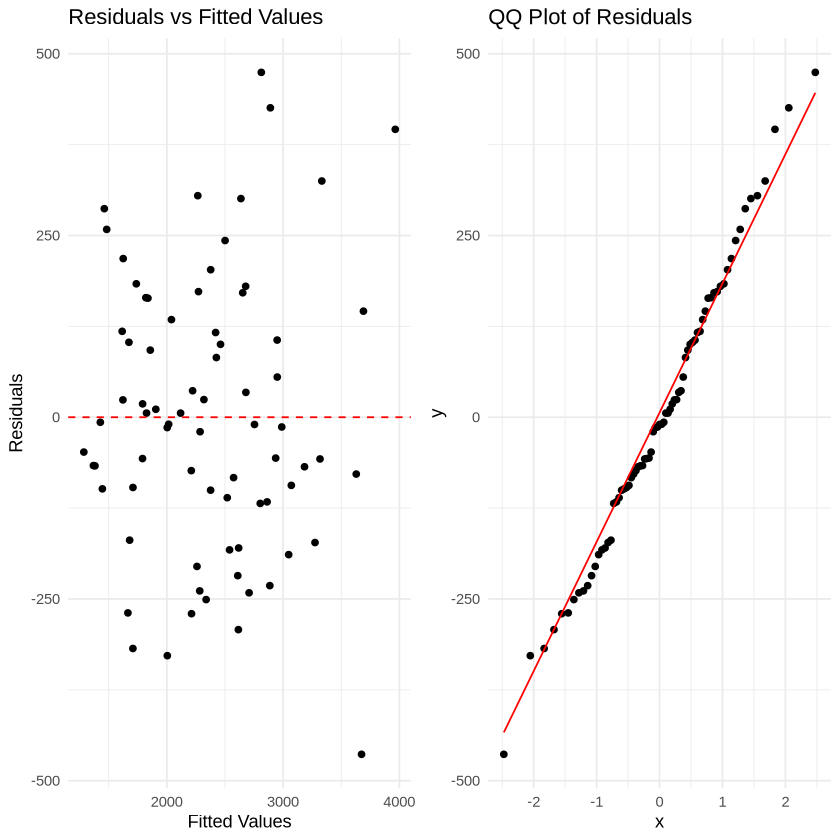

In [12]:
residuals_df = data.frame(
  fitted = reduced_model$fitted.values,
  residuals = reduced_model$residuals
)

# Residuals vs Fitted plot
res_plot = ggplot(residuals_df, aes(x = fitted, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Residuals vs Fitted Values", x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# QQ plot of residuals
qq_plot = ggplot(residuals_df, aes(sample = residuals)) +
  geom_qq() +
  geom_qq_line(color = "red") +
  labs(title = "QQ Plot of Residuals") +
  theme_minimal()

grid.arrange(res_plot, qq_plot, ncol = 2)

On the left, we plotted residuals vs fitted value, and the plot shows no trends or noticeable relationship, allowing us to conclude homoscedasticity of the residuals (constant variance). By analyzing the QQ plot on the right, we see that our errors are normally distributed because they line up very well with the qqline, and do not show any obvious signs of light or heavy tailed distributions.

## 3. Conclusion

### Summary
We first analyzed our data by pre-selecting variables and dropping the ID and sales number fields. Then, we did initial data pre-processing alongside exploraty data analysis. We then checked for multicollinearity issues then used the AIC criterion to do model selection, resulting in a model that regresses on  `ppi`, `core`, `freq`, `memory`, and `thickness`. We then underwent model diagnostics to verify our initial assumptions. A summary of the model statistics is below:

<table>
    <tr>
        <td>
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                </tr>
                <tr>
                    <td>$R^2$</td>
                    <td>0.9144</td>
                </tr>
                <tr>
                    <td>Adjusted $R^2$</td>
                    <td>0.901</td>
                </tr>
            </table>
        </td>
        <td style="padding-left: 30px;">
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                    <th>Expected</th>
                </tr>
                <tr>
                    <td>Mallow's $C_p$</td>
                    <td>10.1530368897259</td>
                    <td>11</td>
                </tr>
            </table>
        </td>
    </tr>
</table>


Being able to explain 90% (adjusted $R^2$) of the variability in price after being penalized is impressive, and our $C_p$ value is nearly as expected, indicating a relatively good model fit.

### Findings
From our final model, we discover that the covariates which contribute positively to the price are `ppi` (screen resolution), `core` (both 4 and 8 cores), `freq`, `memory` (all levels but 8GB). On the other hand, `thickness` and `memory8` are negatively associated with the price.

In addressing our original research question, which focused on the effects of screen resolution (ppi) and the number of cores, we find that `ppi`, `core4`, and `core8` remain significant even after model selection. Their p-values are as follows: 0.00036 for `ppi`, 0.040 for `core4`, and 0.00011 for `core8`.  An interpretation of the coefficients is that each additional more pixel per inch in screen resolution is associated with a $\$1.19$ increase in the price Relative to a baseline level of two cores, 4 cores is associated with an increase in price by $\$226$ while 8 cores is associated with an increase in price by $\$506$. These findings make sense given the nature of the variables: more cores enhance the phone’s performance and require more advanced hardware, while a higher screen resolution results in a sharper display capable of handling high-quality images.

### Business Implications
From the customer’s perspective, our model helps customers understand how different features influence a phone’s price. Knowing this, buyers can evaluate whether a phone is priced unusually high or low without the strong features to support it. From the company’s perspective, manufacturers can use these insights to fine-tune their pricing and product design strategies. Features like higher screen resolution and CPU cores have a strong positive association with price, which supports using them as key differentiators in premium models in segmenting product lines.

### Limitations
The data was collected from an observational study, so there is a risk of confounding variables, such as brand and age of the phone. Since we used an additive regression model, we overlooked interaction effects between variables, which could affect the model's explanatory power. Also, as technology evolves over time, prices of phones based on current tech can change.

### Future Research Questions
Future research could explore confounding variables such as including brand or camera quality, and could also explore interaction effects to reveal relationships between covariates. As prices related to certain technological specs could evolve over time, a study could also consider temporal effects and time series data to predict prices of phones in the future.

## References

Laricchia, F. (2024, October 15). *Number of smartphones sold to end users worldwide from 2007 to 2023*. Statista. https://www.statista.com/statistics/263437/global-smartphone-sales-to-end-users-since-2007/

Sidoti, O., Dawson, W., Gelles-Watnick, R., Faverio, M., Atske, S., Radde, K., & Park, E. (2024, November 13). *Mobile Fact Sheet*. Pew Research Center. https://www.pewresearch.org/internet/fact-sheet/mobile/

Younesi, F. (2022, August 21). *Mobile Price Prediction*. Kaggle. https://www.kaggle.com/datasets/mohannapd/mobile-price-prediction/data